In [1]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

In [2]:
# Loading your IBM Quantum account(s)
token = '01d110f88ee7d5cdfa271e96b5406f92065daa7c967a622b145d0560982310320f66627dc4d02a8d8c114a785a558d4d50ebde4f3540a0cbb5899809f0249d92'
IBMQ.enable_account(token)
IBMQ.providers()

# IBMQ.save_account(token, hub='ibm-q-skku', group='skku', project='skku-students')
# provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='skku-students')
# provider = IBMQ.load_account()
# provider.backends()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>]

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='skku-students')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-skku', group='skku', project='skku-students')>,
 <IBMQS

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import csv
import json
import os
from os.path import exists
import math
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import fowlkes_mallows_score
import statistics

In [3]:
"""
Building Quantum Circuit Part
"""


def buildQAOA(dataset, parameters):
    num = len(dataset)
    weights = calculateWeights(dataset)
    p = len(parameters)//2
    beta = parameters[:p]
    gamma = parameters[p:]
    
    # Init Quantum Circuit
    qc = QuantumCircuit(num)
    
    # Mixer Ground State
    for i in range(num):
        qc.h(i)
    # Evolving
    for i in range(p):
        costFunction(qc, gamma[i], weights)
        mixerHamiltonian(qc, beta[i])

    qc.measure_all()
    return (qc, weights)



def mixerHamiltonian(qc, beta):
    num = qc.num_qubits
    for i in range(num):
        qc.rx(2*beta, i)
    return

def calculateWeights(dataset):
    sh = np.zeros((len(dataset),len(dataset)))
    for i in np.arange(len(dataset)):
        for j in np.arange(len(dataset)):
            distance = np.sqrt((dataset[i][0]-dataset[j][0])**2+(dataset[i][1]-dataset[j][1])**2)
            sh[i][j] = distance
    return sh

    # i1, i2 = qubit index
def costFunctionUnit(qc, gamma, i1, i2, weight):
    qc.p(gamma*weight, i1)
    qc.p(gamma*weight, i2)
    qc.cp(-2*gamma*weight, i1, i2)
    return

def costFunction(qc, gamma, weights):
    num = qc.num_qubits
    for i in range(num):
        for k in range(i+1, num):
            costFunctionUnit(qc, gamma, i, k, weights[i][k])
    return

In [4]:
"""
Optimizing Parameters Part
"""


def countCost(bstring, weights):
    cost = 0
    num = len(bstring)
    for i in range(num):
        for k in range(i+1, num):
            if bstring[num-i-1] != bstring[num-k-1]:
                cost -= weights[i][k]
    return cost

def computeExpectation(counts, weights):
    total_cost = 0
    total_counts = 0
    
    for bstring, count in counts.items():
        cost = countCost(bstring, weights)
        total_cost += cost * count
        total_counts += count
        
    expectation_value = total_cost/total_counts
        
    return expectation_value

def getExpectation(dataset, backend, fname, shots=512):

#     backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def executeCircuit(parameters):
        
        qc, weights = buildQAOA(dataset, parameters)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=shots).result().get_counts()
        bstring = max(counts, key=counts.get)[::-1]
        expectation_value = computeExpectation(counts, weights)
        
        p = len(parameters)//2
        beta = list(parameters[:p])
        gamma = list(parameters[p:])
        
        tmp = {
            bstring: expectation_value,
            "beta": beta,
            "gamma": gamma
        }
       
        
        with open('tmp.json', 'w') as f:
            json.dump(tmp, f)
        
        return expectation_value
    
    return executeCircuit



In [11]:
"""
Execution Part
"""


def runQAOA(dataset, p, backend = None, fname = 'results', shots = 50000):
    if backend == None:
        backend = Aer.get_backend('qasm_simulator')
        
    
    expectation = getExpectation(dataset, backend, fname, shots)
#     init_parameters = np.ones(2*p) # TODO: Need Check
    init_parameters = []
    for i in range(2):
        for k in range(1,p+1):
            db = (0.2-0.05)/p
            dg = (0.4-0.1)/p
            if i == 0:
                init_parameters.append((0.2-db*k)*np.pi)
            else:
                init_parameters.append((0.1+dg*k)*np.pi)
            
    res = minimize(expectation, 
                          init_parameters, 
                          method='COBYLA')
    
    result = []
    with open('tmp.json', 'r') as f:
        tmp = json.load(f)
        tmp = list(zip(tmp.keys(),tmp.values()))[0]
        result.append(tmp)
        
    file_exists = exists(f'{fname}.json')
    if not file_exists:
        with open(f'{fname}.json', 'w') as f:
            empty = {fname:[]}
            json.dump(empty, f)

    """
    json_data = {
    fname: [[bstring, expectation_value], ...]
    }

    """

    with open(f'{fname}.json', 'r') as f:
        json_data = json.load(f)
        json_data[fname].extend(result)

    with open(f'{fname}.json', 'w') as f:
        json.dump(json_data, f)
    
    return res

In [9]:
"""
Experiment Part
"""

qasm_sim = Aer.get_backend('qasm_simulator')

def executeExperiment(dataset, p, fname, exp_shots, backend = qasm_sim):
    for i in range(exp_shots):
        runQAOA(dataset, p, backend, fname)
    return
    
def p_exp(dataset, p=1, fname="test", backend = qasm_sim):
    """
    json_data = {
        1:[[bstring,cost],...],
        2:[[bstring,cost],...],
        ...
    }
    """
    
    n = len(dataset)
    exp_shots = 1
    for i in range(1,p+1):
        executeExperiment(dataset, i, "tmp_p", exp_shots, backend)

        with open('tmp_p.json', 'r') as f:
            tmp_p = json.load(f)
            v = tmp_p.values()
            for k in v:
                p_res = k

        path = os.getcwd()
        os.remove(path+'/tmp_p.json')

        file_exists = exists(f'{fname}.json')
        if not file_exists:
            with open(f'{fname}.json', 'w') as f:
                p_index = str(i)
                json_data = {p_index: p_res}
                json.dump(json_data, f)

        else:
            with open(f'{fname}.json', 'r') as f:
                json_data = json.load(f)
                p_index = str(i)
                json_data[p_index] = p_res

            with open(f'{fname}.json', 'w') as f:
                json.dump(json_data, f)
    return



In [10]:
"""
Experiment Design:
    1. Dataset size: 6 (6 qubit)
    2. Number of Dataset: 20
    3. Range of p: 1-10
    4. Circuit shots: 10000
    5. Full shots: 10
"""

# Making Dataset

# json_data = {}

# while 1:
#     for i in range(20):
#         blobs_points, blobs_y = make_blobs(n_samples=[3, 3], centers=[[0,0], [2,2]], cluster_std=1)

#         bstr = ""
#         for k in blobs_y:
#             bstr += str(k)
#         tmp = list(blobs_points)
#         for k in range(len(tmp)):
#             tmp[k] = list(tmp[k])

#         json_data[bstr] = tmp

#     with open('dataset.json', 'w') as f:
#         json.dump(json_data, f)
#     if len(json_data) == 20:
#         break


# Running QAOA

with open('dataset.json', 'r') as f:
    json_data = json.load(f)

for i in json_data.keys():
    p_exp(json_data[i], p=10, fname=i, backend = qasm_sim)


total_result = {}
for i in range(1,10+1):
    total_result[str(i)] = {}
    for k in json_data.keys():
        with open(f'{k}.json', 'r') as f:
            result_sets = json.load(f)
        result_set = result_sets[str(i)]
        total_result[str(i)][k] = result_set


with open('result.json', 'w') as f:
    json.dump(total_result, f)

In [13]:
"""
Evaluate Score
"""

with open('dataset.json', 'r') as f:
    datasets = json.load(f)

with open('result.json', 'r') as f:
    result = json.load(f)
    
# convert bstr to int
tmp = datasets.keys()
tmp2 = []
for i in tmp:
    tmp2.append(i)

labels_true_list=[]

for i in tmp2:
    tmp3 = []
    for k in i:
        tmp3.append(int(k))
    labels_true_list.append(tmp3)
    

for i in range(10):
    a = 0
    for k in datasets.keys():
        labels_pred_list = []
        for l in range(1):
            labels_pred_list.append(result[str(i+1)][k][l][0])
        
        for l in range(len(labels_pred_list)):
            tmp = []
            for t in labels_pred_list[l]:
                tmp.append(int(t))
            labels_pred_list[l] = tmp

        score = 0
        for l in range(len(labels_pred_list)):
            score += fowlkes_mallows_score (labels_true_list[a], labels_pred_list[l])*100
        score = score
        
        result[str(i+1)][k] = score
        
        a += 1
            

with open('scores.json', 'w') as f:
    json.dump(result, f)

# for i in range(len(tmp2)):
#     labels_true_list.append(labels_true_set[i])
#     dataset = datasets[tmp2[i]]
#     df = np.array(dataset)
#     labels_pred_list.append(executeKmeans(df))

# scores = []
# for i in range(len(labels_pred_list)):
#     scores.append(fowlkes_mallows_score (labels_true_list[i], labels_pred_list[i])*100)

In [34]:
"""
Evaluate Score
"""

with open('dataset.json', 'r') as f:
    datasets = json.load(f)

with open('result_no20_p10_s50000_t1.json', 'r') as f:
    result = json.load(f)
    
# convert bstr to int
tmp = datasets.keys()
tmp2 = []
for i in tmp:
    tmp2.append(i)

labels_true_list=[]

for i in tmp2:
    tmp3 = []
    for k in i:
        tmp3.append(int(k))
    labels_true_list.append(tmp3)
    
std = {}
for i in range(10):
    a = 0
    score = 0
    li = []
    for k in datasets.keys():
        labels_pred_list = []

        for l in range(1):
            labels_pred_list = result[str(i+1)][k][l][1]

#         for l in range(len(labels_pred_list)):
#             tmp = []
#             for t in labels_pred_list[l]:
#                 tmp.append(int(t))
#             labels_pred_list[l] = tmp

        li.append(labels_pred_list)
        score += labels_pred_list
    std[str(i+1)] = statistics.stdev(li)
    result[str(i+1)] = score/20
    
    
        
            

with open('cost_avg.json', 'w') as f:
    json.dump(result, f)
std
# for i in range(len(tmp2)):
#     labels_true_list.append(labels_true_set[i])
#     dataset = datasets[tmp2[i]]
#     df = np.array(dataset)
#     labels_pred_list.append(executeKmeans(df))

# scores = []
# for i in range(len(labels_pred_list)):
#     scores.append(fowlkes_mallows_score (labels_true_list[i], labels_pred_list[i])*100)

{'1': 5.083682644434307,
 '2': 6.091142363008344,
 '3': 5.746919442100608,
 '4': 6.005816298806737,
 '5': 5.034303041219947,
 '6': 5.228913895151132,
 '7': 5.70787855836364,
 '8': 6.4757444973021885,
 '9': 5.51134485942021,
 '10': 5.4913411297540105}

In [14]:
"""
Calculate average of scores
"""


with open('scores.json', 'r') as f:
    scores = json.load(f)

for i in scores.keys():
    avg = 0
    for k in scores[i].values():
        avg += k
    avg = avg/20
    scores[i] = avg

scores

{'1': 60.86066999241839,
 '2': 66.34565722701413,
 '3': 63.02186932726804,
 '4': 65.05943549507194,
 '5': 63.392768828405295,
 '6': 68.26913566135953,
 '7': 76.47883582764712,
 '8': 79.505467331817,
 '9': 79.9358023280262,
 '10': 82.71516749810459}

In [48]:


with open('scores_no20_p10.json', 'r') as f:
    scores = json.load(f)

for i in scores.keys():
    avg = 0
    for k in scores[i].values():
        avg += k
    avg = avg/20
    scores[i] = avg

scores

{'1': 48.43311345630275,
 '2': 50.4802250576939,
 '3': 57.087456229288605,
 '4': 61.726102161738616,
 '5': 62.22063482992161,
 '6': 63.64003516249678,
 '7': 60.924867664392174,
 '8': 61.72610216173861,
 '9': 75.18306866211768,
 '10': 69.01093466363402}

<ipython-input-254-cabd8daba4f3>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


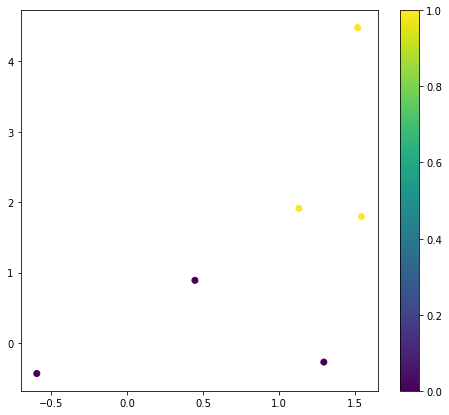

In [254]:
"""
Resource
"""
# making data set
blobs_points, blobs_y = make_blobs(n_samples=[3, 3], centers=[[0,0], [2,2]], cluster_std=1)

# execution comparing p experiment
p_exp(blobs_points, p=3, fname="test_p", backend = qasm_sim)

# Ploting
f = plt.figure(figsize=(8, 7))
clr = plt.scatter(blobs_points[:, 0], blobs_points[:, 1], c=blobs_y)
plt.colorbar(clr)
f.show()

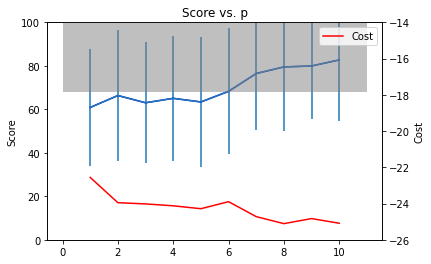

In [53]:
import matplotlib.pyplot as plt

# Ploting
# f = plt.figure(figsize=(8, 7))
# clr = plt.scatter(blobs_points[:, 0], blobs_points[:, 1], c=blobs_y)
# plt.colorbar(clr)
# f.show()

# plt.plot(x,y,'b',label='first')
# plt.plot(x,y2,'r',label='second')
# plt.xlabel('x axis')
# plt.ylabel('y axis')
# plt.title('matplotlib sample')
# plt.legend(loc='upper right')
# plt.show()


##

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = np.arange(1,11,1)

sim_score_avg = [60.86066999241839,66.34565722701413,63.02186932726804,65.05943549507194,63.392768828405295,68.26913566135953,76.47883582764712,79.505467331817,79.9358023280262,82.71516749810459]
sim_score_std = [26.6938043082803,30.20121530091333,27.807480872409673,28.856803938578764,29.988993301652677,29.01256672127022,26.017224305029192,29.693359581590258,24.164174234623186,28.161922052351702]

sim_cost_avg = [-22.55818984556026,-23.95119520407917,-24.01950615728054,-24.12437597015812,-24.283924023084495,-23.896316412833507,-24.721212376494613,-25.108013056236405,-24.829499305065653,-25.086805754155307]
sim_cost_std = [5.083682644434307,6.091142363008344,5.746919442100608,6.005816298806737,5.034303041219947,5.228913895151132,5.70787855836364,6.4757444973021885,5.51134485942021,5.4913411297540105]

kmeans_avg = 87.5082
kmeans_std = 19.758498424568543

ax1.plot(x,sim_score_avg,'b',label='Score')
ax1.set_ylim(0,100)

ax2.plot(x,sim_cost_avg,'r',label='Cost')
ax2.set_ylim(-26,-14)

plt.xlabel('p')
ax1.set_ylabel('Score')
ax2.set_ylabel('Cost')

plt.title('Score vs. p')
plt.legend(loc='upper right')


span_start = (kmeans_avg-kmeans_std)/100
span_end = (kmeans_avg+kmeans_std)/100

plt.axvspan(0,11,span_start, span_end, facecolor='gray', alpha=0.5)



ax1.errorbar(x, sim_score_avg, yerr=sim_score_std, label='both limits (default)')

# plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')

# plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
#              label='uplims=True, lolims=True')

plt.show()




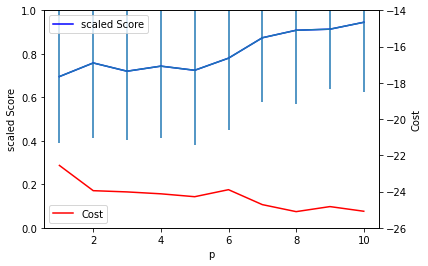

In [73]:
import matplotlib.pyplot as plt

##

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = np.arange(1,11,1)

sim_score_avg = [60.86066999241839,66.34565722701413,63.02186932726804,65.05943549507194,63.392768828405295,68.26913566135953,76.47883582764712,79.505467331817,79.9358023280262,82.71516749810459]
sim_score_avg = [i/87.5082 for i in sim_score_avg]

sim_score_std = [26.6938043082803,30.20121530091333,27.807480872409673,28.856803938578764,29.988993301652677,29.01256672127022,26.017224305029192,29.693359581590258,24.164174234623186,28.161922052351702]
sim_score_std = [i/87.5082 for i in sim_score_std]

sim_cost_avg = [-22.55818984556026,-23.95119520407917,-24.01950615728054,-24.12437597015812,-24.283924023084495,-23.896316412833507,-24.721212376494613,-25.108013056236405,-24.829499305065653,-25.086805754155307]
sim_cost_std = [5.083682644434307,6.091142363008344,5.746919442100608,6.005816298806737,5.034303041219947,5.228913895151132,5.70787855836364,6.4757444973021885,5.51134485942021,5.4913411297540105]

kmeans_avg = 87.5082
kmeans_std = 19.758498424568543

ax1.plot(x,sim_score_avg,'b',label='scaled Score')
ax1.set_ylim(0,1)
ax1.legend(loc='upper left')

ax2.plot(x,sim_cost_avg,'r',label='Cost')
ax2.set_ylim(-26,-14)
ax2.legend(loc='lower left')

ax1.set_xlabel('p', fontsize=10)
ax1.set_ylabel('scaled Score', fontsize=10)
ax2.set_ylabel('Cost', fontsize=10)

# plt.title('', fontsize = 20)






ax1.errorbar(x, sim_score_avg, yerr=sim_score_std, label='both limits (default)')


plt.show()




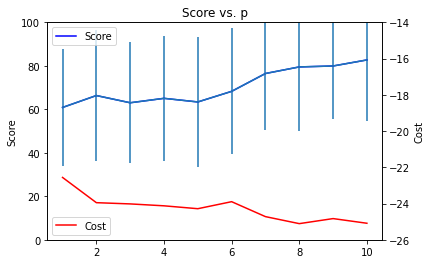

In [66]:
import matplotlib.pyplot as plt

##

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

x = np.arange(1,11,1)

sim_score_avg = [60.86066999241839,66.34565722701413,63.02186932726804,65.05943549507194,63.392768828405295,68.26913566135953,76.47883582764712,79.505467331817,79.9358023280262,82.71516749810459]
sim_score_std = [26.6938043082803,30.20121530091333,27.807480872409673,28.856803938578764,29.988993301652677,29.01256672127022,26.017224305029192,29.693359581590258,24.164174234623186,28.161922052351702]

sim_cost_avg = [-22.55818984556026,-23.95119520407917,-24.01950615728054,-24.12437597015812,-24.283924023084495,-23.896316412833507,-24.721212376494613,-25.108013056236405,-24.829499305065653,-25.086805754155307]
sim_cost_std = [5.083682644434307,6.091142363008344,5.746919442100608,6.005816298806737,5.034303041219947,5.228913895151132,5.70787855836364,6.4757444973021885,5.51134485942021,5.4913411297540105]

kmeans_avg = 87.5082
kmeans_std = 19.758498424568543

ax1.plot(x,sim_score_avg,'b',label='Score')
ax1.set_ylim(0,100)
ax1.legend(loc='upper left')

ax2.plot(x,sim_cost_avg,'r',label='Cost')
ax2.set_ylim(-26,-14)
ax2.legend(loc='lower left')

plt.xlabel('p')
ax1.set_ylabel('Score')
ax2.set_ylabel('Cost')

plt.title('Score vs. p')






ax1.errorbar(x, sim_score_avg, yerr=sim_score_std, label='both limits (default)')


plt.show()


